## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
import keras
import numpy.matlib
import mat73
import colorcet as cc

from numpy import asarray
from scipy import stats, signal, io
from scipy.ndimage import median_filter as medfilt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from utils import tic, toc, hankel_matrix, scaler, legendre_polys, find_opt_lag
from models import linear_regression, VAE

%matplotlib notebook

2024-03-18 14:49:22.018111: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-18 14:49:22.141381: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-18 14:49:22.591049: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-03-18 14:49:22.591101: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

## Load and preprocess data

In [2]:
#data_dir = '/home/ryraut/code/arousal'
data_dir = '/home/ryanr/widefield'
mask = io.loadmat(data_dir+'/newmask.mat')
mask = mask["newmask"]
mask.dtype = bool
mask_long = mask.reshape(16384,order='F')
allen_ccf = mat73.loadmat(data_dir + '/allen_ccf_overlay.mat')['allen_ccf']

In [3]:
s = 1

data_dict = mat73.loadmat(data_dir + '/' + str(s) + '_pupil.mat')
pupil = data_dict['pupil'].reshape(-1,1)
data_dict = mat73.loadmat(data_dir + '/' + str(s) + '_jrgeco.mat')
brain = data_dict['data'][:,mask_long]
data_dict = mat73.loadmat(data_dir + '/' + str(s) + '_face.mat')
face = data_dict['face'].reshape(-1,1)

# remove initial transient
pupil = pupil[800:,:]
brain = brain[800:,:]
face = face[800:,:]

pupil = medfilt(pupil,21)

Fs = 20
dt = 1/Fs
sos = signal.butter(1, [.01,.2],btype = 'bandpass', output = 'sos', fs = Fs)

pupil = signal.sosfiltfilt(sos, pupil, axis = 0)
brain = signal.sosfiltfilt(sos, brain, axis = 0)

## Analysis

In [4]:
## Set delay embedding parameters

delay = 1 # implement delay embedding? 0 or 1
nonlinear = 1 # use nonlinear mappings (VAE) (as opposed to linear regression) ? 0 or 1
Fs = 20 # sampling frequency
dt = 1/Fs
stackmax = 100 # Hankel row dimension (i.e., number of time shifts)
spacing = 3 # number of samples separating each row
r = 10 # number of modes of the Hankel matrix to keep (used for projection onto top r Legendre polynomials)
z_n = 4 # number of latent dimensions used for VAE
anneal_step = 1000 # determines rate at which KL loss is increased during training
beta = .1 # beta weight for KL loss in VAE training
num_epochs = 200 # number of training epochs

In [5]:
## Train-test split
xtrain, xtest, ytrain, ytest = train_test_split(pupil,brain,test_size=brain.shape[0]-6000,shuffle=False)

xtest = xtest[1000:,:] # enforce 50s (50/dt) gap to mitigate overlap between train and test
ytest = ytest[1000:,:]

In [6]:
## Adjust for pupil:brain lag

# Find lag
lag_range = 5 # range over which to look for optimal lag between pupil and brain cross-correlation (in seconds)
lag_range = int(lag_range/dt)
lag,_,_ = find_opt_lag(xtrain,np.mean(ytrain,axis=1),lag_range)

# Adjust
if lag:
    xtrain = xtrain[lag:,:]
    ytrain = ytrain[:-lag,:]
    
    xtest = xtest[lag:,:]
    ytest = ytest[:-lag,:]

In [7]:
## Time delay embedding    
if delay:
    polys = legendre_polys(r, stackmax)

    Hp_train = hankel_matrix(xtrain.T,stackmax,spacing)
    Hp_test = hankel_matrix(xtest.T,stackmax,spacing)

    xtrain = Hp_train.T@polys
    xtest = Hp_test.T@polys
    
else:
    xtrain = xtrain[spacing*(stackmax-1):,:]
    xtest = xtest[spacing*(stackmax-1):,:]

ytrain = ytrain[spacing*(stackmax-1):,:]
ytest = ytest[spacing*(stackmax-1):,:]

In [8]:
## Preprocessing
xtrain_sc, scale_x = scaler(xtrain)
ytrain_sc, scale_y = scaler(ytrain)

In [9]:
## Train model
if nonlinear:
    r_squared, model, encoder, decoder = VAE(xtrain_sc, ytrain_sc, latent_dim=z_n, beta=beta, num_epochs=num_epochs, anneal_step=anneal_step)
else:
    r_squared, model = linear_regression(xtrain_sc, ytrain_sc)

ytrain_hat_sc = model.predict(xtrain_sc)

r_squared

2024-03-18 14:49:30.196729: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-18 14:49:32.075150: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9633 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:19:00.0, compute capability: 7.5
2024-03-18 14:49:32.076559: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9633 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5
2024-03-18 14:49:32.077857: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/repli

Epoch 1/200
6/6 [==============================] - 1s 15ms/step - loss: 0.0982 - reconstruction_loss: 0.0988 - kl_loss: 8.7037e-06 - kl_anneal: 2.8571e-04
Epoch 2/200
6/6 [==============================] - 0s 14ms/step - loss: 0.0918 - reconstruction_loss: 0.0904 - kl_loss: 3.0224e-05 - kl_anneal: 8.8571e-04
Epoch 3/200
6/6 [==============================] - 0s 14ms/step - loss: 0.0799 - reconstruction_loss: 0.0750 - kl_loss: 5.8349e-05 - kl_anneal: 0.0015
Epoch 4/200
6/6 [==============================] - 0s 14ms/step - loss: 0.0607 - reconstruction_loss: 0.0587 - kl_loss: 1.0122e-04 - kl_anneal: 0.0021
Epoch 5/200
6/6 [==============================] - 0s 13ms/step - loss: 0.0534 - reconstruction_loss: 0.0519 - kl_loss: 1.7297e-04 - kl_anneal: 0.0027
Epoch 6/200
6/6 [==============================] - 0s 15ms/step - loss: 0.0494 - reconstruction_loss: 0.0491 - kl_loss: 2.9286e-04 - kl_anneal: 0.0033
Epoch 7/200
6/6 [==============================] - 0s 13ms/step - loss: 0.0456 - recon

6/6 [==============================] - 0s 13ms/step - loss: 0.0286 - reconstruction_loss: 0.0255 - kl_loss: 0.0033 - kl_anneal: 0.0333
Epoch 57/200
6/6 [==============================] - 0s 13ms/step - loss: 0.0290 - reconstruction_loss: 0.0258 - kl_loss: 0.0033 - kl_anneal: 0.0339
Epoch 58/200
6/6 [==============================] - 0s 14ms/step - loss: 0.0291 - reconstruction_loss: 0.0257 - kl_loss: 0.0033 - kl_anneal: 0.0345
Epoch 59/200
6/6 [==============================] - 0s 15ms/step - loss: 0.0289 - reconstruction_loss: 0.0257 - kl_loss: 0.0034 - kl_anneal: 0.0351
Epoch 60/200
6/6 [==============================] - 0s 14ms/step - loss: 0.0291 - reconstruction_loss: 0.0258 - kl_loss: 0.0033 - kl_anneal: 0.0357
Epoch 61/200
6/6 [==============================] - 0s 15ms/step - loss: 0.0289 - reconstruction_loss: 0.0255 - kl_loss: 0.0034 - kl_anneal: 0.0363
Epoch 62/200
6/6 [==============================] - 0s 14ms/step - loss: 0.0289 - reconstruction_loss: 0.0256 - kl_loss: 0.00

6/6 [==============================] - 0s 15ms/step - loss: 0.0288 - reconstruction_loss: 0.0249 - kl_loss: 0.0041 - kl_anneal: 0.0663
Epoch 112/200
6/6 [==============================] - 0s 15ms/step - loss: 0.0290 - reconstruction_loss: 0.0248 - kl_loss: 0.0041 - kl_anneal: 0.0669
Epoch 113/200
6/6 [==============================] - 0s 14ms/step - loss: 0.0287 - reconstruction_loss: 0.0246 - kl_loss: 0.0042 - kl_anneal: 0.0675
Epoch 114/200
6/6 [==============================] - 0s 15ms/step - loss: 0.0288 - reconstruction_loss: 0.0248 - kl_loss: 0.0042 - kl_anneal: 0.0681
Epoch 115/200
6/6 [==============================] - 0s 13ms/step - loss: 0.0290 - reconstruction_loss: 0.0247 - kl_loss: 0.0042 - kl_anneal: 0.0687
Epoch 116/200
6/6 [==============================] - 0s 15ms/step - loss: 0.0289 - reconstruction_loss: 0.0246 - kl_loss: 0.0042 - kl_anneal: 0.0693
Epoch 117/200
6/6 [==============================] - 0s 14ms/step - loss: 0.0289 - reconstruction_loss: 0.0248 - kl_loss

6/6 [==============================] - 0s 14ms/step - loss: 0.0292 - reconstruction_loss: 0.0245 - kl_loss: 0.0048 - kl_anneal: 0.0993
Epoch 167/200
6/6 [==============================] - 0s 14ms/step - loss: 0.0292 - reconstruction_loss: 0.0244 - kl_loss: 0.0048 - kl_anneal: 0.0999
Epoch 168/200
6/6 [==============================] - 0s 14ms/step - loss: 0.0292 - reconstruction_loss: 0.0246 - kl_loss: 0.0048 - kl_anneal: 0.1000
Epoch 169/200
6/6 [==============================] - 0s 14ms/step - loss: 0.0296 - reconstruction_loss: 0.0249 - kl_loss: 0.0048 - kl_anneal: 0.1000
Epoch 170/200
6/6 [==============================] - 0s 13ms/step - loss: 0.0293 - reconstruction_loss: 0.0245 - kl_loss: 0.0048 - kl_anneal: 0.1000
Epoch 171/200
6/6 [==============================] - 0s 13ms/step - loss: 0.0293 - reconstruction_loss: 0.0246 - kl_loss: 0.0047 - kl_anneal: 0.1000
Epoch 172/200
6/6 [==============================] - 0s 14ms/step - loss: 0.0294 - reconstruction_loss: 0.0244 - kl_loss

0.800299597196932

In [10]:
## Test model
xtest_sc,_ = scaler(xtest, scale_x)
ytest_sc,_ = scaler(ytest, scale_y)
ytest = scale_y.inverse_transform(ytest_sc) # scaling/unscaling essentially corrects for mean offset

ytest_hat_sc = model.predict(xtest_sc)
ytest_hat = scale_y.inverse_transform(ytest_hat_sc)

r2_score(ytest, ytest_hat, multioutput='variance_weighted')

0.6289417298831462

## Visualize

In [11]:
## Project back to brain

data1 = ytest
data2 = ytest_hat

outmat1 = np.zeros((data1.shape[0],16384), dtype=np.single)
outmat1[:,mask_long] = StandardScaler(with_std=False).fit_transform(data1)
outmat1 = np.ma.masked_where(outmat1==0, outmat1)
outmat1 = outmat1.reshape(data1.shape[0],128,128,order='F')

outmat2 = np.zeros((data2.shape[0],16384), dtype=np.single)
outmat2[:,mask_long] = StandardScaler(with_std=False).fit_transform(data2)
outmat2 = np.ma.masked_where(outmat2==0, outmat2)
outmat2 = outmat2.reshape(data2.shape[0],128,128,order='F')

<IPython.core.display.Javascript object>


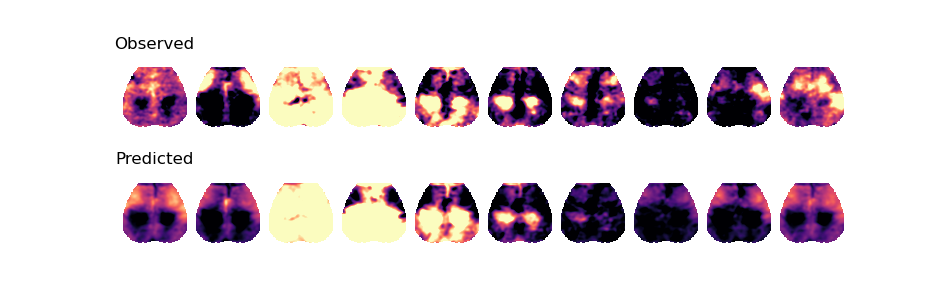

In [12]:
nframes = 10
step = 80
offset = 2179

fig, axes = plt.subplots(2,nframes,sharex='col',figsize=(9.42,3))

c1 = .005
c2 = c1

axes = axes.flatten()
for i, ax in enumerate(axes):
    
    if i<nframes:
        ax.imshow(outmat1[i*step + offset,:,:], vmin=-c1, vmax=c1, cmap = 'magma')
        
    else:
        ax.imshow(outmat2[(i-nframes)*step + offset,:,:], vmin=-c2, vmax=c2, cmap = 'magma')    

    ax.axis('off')

axes[0].set_title('Observed')
axes[nframes].set_title('Predicted')
    
plt.subplots_adjust(wspace=0, hspace=0)

plt.show()
